### Libraries 📚⬇

In [1]:
!nvidia-smi

Fri Aug  2 14:51:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    Off | 00000000:00:05.0 Off |                    0 |
| 30%   54C    P2              72W / 300W |   1741MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch

# Check CUDA availability
print(f"CUDA is available: {torch.cuda.is_available()}")
print(torch.version.cuda)
# Print CUDA device count
if torch.cuda.is_available():
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")

CUDA is available: True
12.1
Number of CUDA devices: 2


In [4]:
# load pretrained models
load_pretrained_models = False
# number of epochs of training
n_epochs = 20
# size of the batches
batch_size = 16
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of second order momentum of gradient
b2 = 0.999
# epoch from which to start lr decay
decay_epoch = 500
# number of cpu threads to use during batch generation
n_cpu = 8
# high res. image height
hr_height = 512
# high res. image width
hr_width = 512
# number of image channels
channels = 3

os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)

In [5]:
%ls

'7-Detection data'/            images/         srgan_code.ipynb
 Srgan_data_generation.ipynb   saved_models/   srgan_model.ipynb


In [6]:
import os


In [7]:
os.listdir('7-Detection data')

['low_Mobile_crane-20240709T043315Z-001.zip',
 'Mobile_crane-20240709T043321Z-001.zip',
 'low_Tower_crane',
 'low_Mobile_crane',
 'Tower_crane',
 'Tower_crane-20240709T043326Z-001.zip',
 'low_Tower_crane-20240709T043317Z-001.zip',
 'Mobile_crane']

### Settings ⚙️

### Define Dataset Class

In [8]:
import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# # Normalization parameters
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])

class ImageDataset(Dataset):
    def __init__(self, low_paths, high_paths):
        # Define transforms for images
        self.transform_lr = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()

        ])

        self.transform_hr = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()
        ])

        self.low_paths = low_paths
        self.high_paths = high_paths

    def __getitem__(self, index):
        img_low = Image.open(self.low_paths[index % len(self.low_paths)])
        img_high = Image.open(self.high_paths[index % len(self.high_paths)])

        img_lr = self.transform_lr(img_low)
        img_hr = self.transform_hr(img_high)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return max(len(self.low_paths), len(self.high_paths))

In [9]:
len(os.listdir('7-Detection data/Mobile_crane')),len(os.listdir('7-Detection data/low_Mobile_crane'))

(2009, 2009)

In [10]:
len(os.listdir('7-Detection data/Tower_crane'))

2022

In [11]:
import glob

dataset_path = '7-Detection data'

low_paths1 = glob.glob(dataset_path + "/low_Mobile_crane/*.*")
low_paths2 = glob.glob(dataset_path + "/low_Tower_crane/*.*")
high_paths1 = glob.glob(dataset_path + "/Mobile_crane/*.*")
high_paths2 = glob.glob(dataset_path + "/Tower_crane/*.*")


low_paths = sorted(low_paths1 + low_paths2)
high_paths = sorted(high_paths1 + high_paths2)

print(len(low_paths))
print(len(high_paths))

4031
4031


In [12]:
# low_paths=low_paths[:1500]
# high_paths=high_paths[:1500]

In [13]:
train_low_paths, test_low_paths = train_test_split(low_paths, test_size=0.2, random_state=42)
train_high_paths, test_high_paths = train_test_split(high_paths, test_size=0.2, random_state=42)

batch_size = 8
n_cpu = 2

In [14]:
print(len(train_low_paths))
print(len(train_high_paths))

3224
3224


In [15]:
print(len(test_low_paths))
print(len(test_high_paths))

807
807


### Get Train/Test Dataloaders

In [16]:
train_dataset = ImageDataset(train_low_paths, train_high_paths)
test_dataset = ImageDataset(test_low_paths, test_high_paths)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=int(batch_size), shuffle=False,num_workers=4)

### Define Model Classes

In [17]:
# class FeatureExtractor(nn.Module):
#     def __init__(self):
#         super(FeatureExtractor, self).__init__()
#         vgg19_model = vgg19(pretrained=True)
#         self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

#     def forward(self, img):
#         return self.feature_extractor(img)


# class ResidualBlock(nn.Module):
#     def __init__(self, in_features):
#         super(ResidualBlock, self).__init__()
#         self.conv_block = nn.Sequential(
#             nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(in_features, 0.8),
#             nn.PReLU(),
#             nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(in_features, 0.8),
#         )

#     def forward(self, x):
#         return x + self.conv_block(x)


# class GeneratorVGG(nn.Module):
#     def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
#         super(GeneratorVGG, self).__init__()

#         # First layer
#         self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

#         # Residual blocks
#         res_blocks = []
#         for _ in range(n_residual_blocks):
#             res_blocks.append(ResidualBlock(64))
#         self.res_blocks = nn.Sequential(*res_blocks)

#         # Second conv layer post residual blocks
#         self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

#         # Upsampling layers
#         upsampling = []
#         for out_features in range(2):
#             upsampling += [
#                 # nn.Upsample(scale_factor=2),
#                 nn.Conv2d(64, 256, 3, 1, 1),
#                 nn.BatchNorm2d(256),
#                 nn.PixelShuffle(upscale_factor=2),
#                 nn.PReLU(),
#             ]
#         self.upsampling = nn.Sequential(*upsampling)

#         # Final output layer
#         self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Sigmoid())

#     def forward(self, x):
#         out1 = self.conv1(x)
#         out = self.res_blocks(out1)
#         out2 = self.conv2(out)
#         out = torch.add(out1, out2)
#         out = self.upsampling(out)
#         out = self.conv3(out)
#         # Clamp the output to [0, 1] range
#         out = torch.clamp(out, min=0.0, max=1.0)
#         return out


# class Discriminator(nn.Module):
#     def __init__(self, input_shape):
#         super(Discriminator, self).__init__()

#         self.input_shape = input_shape
#         in_channels, in_height, in_width = self.input_shape
#         patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
#         self.output_shape = (1, patch_h, patch_w)

#         def discriminator_block(in_filters, out_filters, first_block=False):
#             layers = []
#             layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
#             if not first_block:
#                 layers.append(nn.BatchNorm2d(out_filters))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
#             layers.append(nn.BatchNorm2d(out_filters))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             return layers

#         layers = []
#         in_filters = in_channels
#         for i, out_filters in enumerate([64, 128, 256, 512]):
#             layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
#             in_filters = out_filters

#         layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

#         self.model = nn.Sequential(*layers)

#     def forward(self, img):
#         return self.model(img)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorVGG(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorVGG, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64))

        # Upsampling layers
        upsampling = []
        for out_features in range(3):
            upsampling += [
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Sigmoid())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        # Clamp the output to [0, 1] range
        out = torch.clamp(out, min=0.0, max=1.0)
        return out

class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [19]:
# Initialize generator and discriminator
generator = GeneratorVGG()
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

### Train Super Resolution GAN (SRGAN)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM

In [21]:

generator.load_state_dict(torch.load("saved_models/generator.pth"))
discriminator.load_state_dict(torch.load("saved_models/discriminator.pth"))

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
train_gen_losses, train_disc_losses, train_psnr_values = [], [], []
test_gen_losses, test_disc_losses, test_psnr_values = [], [], []

# Assuming test_counter initialization elsewhere in your code
n_epochs=200
for epoch in range(n_epochs):

    ### Training
    epoch_gen_loss, epoch_disc_loss = 0, 0
    epoch_psnr = 0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=len(train_dataloader))

    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.train()
        discriminator.train()

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        ### Train Generator
        optimizer_G.zero_grad()
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN
        loss_G.backward()
        optimizer_G.step()

        ### Train Discriminator
        optimizer_D.zero_grad()
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # Accumulate losses
        epoch_gen_loss += loss_G.item()
        epoch_disc_loss += loss_D.item()

        # Calculate PSNR
        imgs_hr_np = imgs_hr.cpu().detach().numpy()
        gen_hr_np = gen_hr.cpu().detach().numpy()
        psnr_value = PSNR(imgs_hr_np, gen_hr_np, data_range=1.0)
        epoch_psnr += psnr_value

        tqdm_bar.set_postfix(gen_loss=epoch_gen_loss/(batch_idx+1), disc_loss=epoch_disc_loss/(batch_idx+1), PSNR=f"{epoch_psnr/(batch_idx+1):.4f}")

    # Append epoch metrics to the lists
    train_gen_losses.append(epoch_gen_loss / len(train_dataloader))
    train_disc_losses.append(epoch_disc_loss / len(train_dataloader))
    train_psnr_values.append(epoch_psnr / len(train_dataloader))

    ### Testing (Validation)
    epoch_gen_loss, epoch_disc_loss = 0, 0
    epoch_psnr = 0
    tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=len(test_dataloader))

    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.eval()
        discriminator.eval()

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        ### Eval Generator
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        ### Eval Discriminator
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        # Accumulate losses
        epoch_gen_loss += loss_G.item()
        epoch_disc_loss += loss_D.item()

        # Calculate PSNR
        imgs_hr_np = imgs_hr.cpu().detach().numpy()
        gen_hr_np = gen_hr.cpu().detach().numpy()
        psnr_value = PSNR(imgs_hr_np, gen_hr_np, data_range=1.0)
        epoch_psnr += psnr_value

        tqdm_bar.set_postfix(gen_loss=epoch_gen_loss/(batch_idx+1), disc_loss=epoch_disc_loss/(batch_idx+1), PSNR=f"{epoch_psnr/(batch_idx+1):.4f}")

    # Append epoch metrics to the lists
    test_gen_losses.append(epoch_gen_loss / len(test_dataloader))
    test_disc_losses.append(epoch_disc_loss / len(test_dataloader))
    test_psnr_values.append(epoch_psnr / len(test_dataloader))

    # Save model checkpoints based on validation loss
    if np.argmin(test_gen_losses) == len(test_gen_losses) - 1:
        torch.save(generator.state_dict(), "saved_models/generator.pth")
        torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")
        print("saved")


Training Epoch 0 : 100%|█| 403/403 [02:56<00:00,  2.28it/s, PSNR=14.9733, disc_l
Testing Epoch 0 : 100%|█| 101/101 [00:17<00:00,  5.79it/s, PSNR=15.0692, disc_lo


saved


Training Epoch 1 : 100%|█| 403/403 [02:57<00:00,  2.28it/s, PSNR=15.0162, disc_l
Testing Epoch 1 : 100%|█| 101/101 [00:17<00:00,  5.69it/s, PSNR=15.1779, disc_lo
Training Epoch 2 : 100%|█| 403/403 [02:56<00:00,  2.28it/s, PSNR=15.0554, disc_l
Testing Epoch 2 : 100%|█| 101/101 [00:17<00:00,  5.83it/s, PSNR=15.1923, disc_lo


saved


Training Epoch 3 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.0599, disc_l
Testing Epoch 3 : 100%|█| 101/101 [00:17<00:00,  5.66it/s, PSNR=15.0923, disc_lo
Training Epoch 4 : 100%|█| 403/403 [02:56<00:00,  2.29it/s, PSNR=15.0727, disc_l
Testing Epoch 4 : 100%|█| 101/101 [00:17<00:00,  5.82it/s, PSNR=15.2408, disc_lo
Training Epoch 5 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.0923, disc_l
Testing Epoch 5 : 100%|█| 101/101 [00:17<00:00,  5.82it/s, PSNR=15.1535, disc_lo


saved


Training Epoch 6 : 100%|█| 403/403 [02:55<00:00,  2.29it/s, PSNR=15.1079, disc_l
Testing Epoch 6 : 100%|█| 101/101 [00:17<00:00,  5.84it/s, PSNR=15.1581, disc_lo
Training Epoch 7 : 100%|█| 403/403 [02:55<00:00,  2.30it/s, PSNR=15.1029, disc_l
Testing Epoch 7 : 100%|█| 101/101 [00:17<00:00,  5.94it/s, PSNR=15.1935, disc_lo
Training Epoch 8 : 100%|█| 403/403 [02:56<00:00,  2.29it/s, PSNR=15.1191, disc_l
Testing Epoch 8 : 100%|█| 101/101 [00:17<00:00,  5.74it/s, PSNR=15.2256, disc_lo
Training Epoch 9 : 100%|█| 403/403 [02:55<00:00,  2.29it/s, PSNR=15.1086, disc_l
Testing Epoch 9 : 100%|█| 101/101 [00:16<00:00,  6.05it/s, PSNR=15.2990, disc_lo
Training Epoch 10 : 100%|█| 403/403 [02:55<00:00,  2.29it/s, PSNR=15.1238, disc_
Testing Epoch 10 : 100%|█| 101/101 [00:17<00:00,  5.87it/s, PSNR=15.3244, disc_l


saved


Training Epoch 11 : 100%|█| 403/403 [02:54<00:00,  2.31it/s, PSNR=15.1404, disc_
Testing Epoch 11 : 100%|█| 101/101 [00:17<00:00,  5.85it/s, PSNR=15.0600, disc_l
Training Epoch 12 : 100%|█| 403/403 [02:55<00:00,  2.30it/s, PSNR=15.1340, disc_
Testing Epoch 12 : 100%|█| 101/101 [00:17<00:00,  5.85it/s, PSNR=15.2919, disc_l
Training Epoch 13 : 100%|█| 403/403 [02:55<00:00,  2.30it/s, PSNR=15.1505, disc_
Testing Epoch 13 : 100%|█| 101/101 [00:17<00:00,  5.88it/s, PSNR=15.2010, disc_l
Training Epoch 14 : 100%|█| 403/403 [02:54<00:00,  2.31it/s, PSNR=15.1596, disc_
Testing Epoch 14 : 100%|█| 101/101 [00:16<00:00,  5.95it/s, PSNR=15.1892, disc_l
Training Epoch 15 : 100%|█| 403/403 [02:52<00:00,  2.34it/s, PSNR=15.1598, disc_
Testing Epoch 15 : 100%|█| 101/101 [00:17<00:00,  5.86it/s, PSNR=15.2294, disc_l
Training Epoch 16 : 100%|█| 403/403 [02:53<00:00,  2.32it/s, PSNR=15.1643, disc_
Testing Epoch 16 : 100%|█| 101/101 [00:17<00:00,  5.73it/s, PSNR=15.4298, disc_l
Training Epoch 17 : 100%|█| 

saved


Training Epoch 18 : 100%|█| 403/403 [02:56<00:00,  2.28it/s, PSNR=15.1781, disc_
Testing Epoch 18 : 100%|█| 101/101 [00:17<00:00,  5.83it/s, PSNR=15.1501, disc_l
Training Epoch 19 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.1799, disc_
Testing Epoch 19 : 100%|█| 101/101 [00:18<00:00,  5.61it/s, PSNR=15.3635, disc_l
Training Epoch 20 : 100%|█| 403/403 [02:58<00:00,  2.26it/s, PSNR=15.1839, disc_
Testing Epoch 20 : 100%|█| 101/101 [00:17<00:00,  5.65it/s, PSNR=15.4374, disc_l
Training Epoch 21 : 100%|█| 403/403 [02:58<00:00,  2.26it/s, PSNR=15.1744, disc_
Testing Epoch 21 : 100%|█| 101/101 [00:17<00:00,  5.81it/s, PSNR=15.1413, disc_l
Training Epoch 22 : 100%|█| 403/403 [02:58<00:00,  2.26it/s, PSNR=15.1837, disc_
Testing Epoch 22 : 100%|█| 101/101 [00:17<00:00,  5.83it/s, PSNR=15.4193, disc_l
Training Epoch 23 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.1902, disc_
Testing Epoch 23 : 100%|█| 101/101 [00:16<00:00,  6.00it/s, PSNR=15.3904, disc_l
Training Epoch 24 : 100%|█| 

saved


Training Epoch 28 : 100%|█| 403/403 [02:56<00:00,  2.29it/s, PSNR=15.2129, disc_
Testing Epoch 28 : 100%|█| 101/101 [00:16<00:00,  6.00it/s, PSNR=15.2868, disc_l


saved


Training Epoch 29 : 100%|█| 403/403 [02:53<00:00,  2.32it/s, PSNR=15.2126, disc_
Testing Epoch 29 : 100%|█| 101/101 [00:17<00:00,  5.69it/s, PSNR=15.2583, disc_l
Training Epoch 30 : 100%|█| 403/403 [02:55<00:00,  2.29it/s, PSNR=15.2197, disc_
Testing Epoch 30 : 100%|█| 101/101 [00:17<00:00,  5.86it/s, PSNR=15.3328, disc_l
Training Epoch 31 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.2309, disc_
Testing Epoch 31 : 100%|█| 101/101 [00:17<00:00,  5.65it/s, PSNR=15.4353, disc_l
Training Epoch 32 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.2391, disc_
Testing Epoch 32 : 100%|█| 101/101 [00:18<00:00,  5.56it/s, PSNR=15.1883, disc_l
Training Epoch 33 : 100%|█| 403/403 [02:55<00:00,  2.29it/s, PSNR=15.2152, disc_
Testing Epoch 33 : 100%|█| 101/101 [00:17<00:00,  5.67it/s, PSNR=15.3076, disc_l
Training Epoch 34 : 100%|█| 403/403 [02:58<00:00,  2.26it/s, PSNR=15.2461, disc_
Testing Epoch 34 : 100%|█| 101/101 [00:17<00:00,  5.65it/s, PSNR=15.3996, disc_l
Training Epoch 35 : 100%|█| 

saved


Training Epoch 43 : 100%|█| 403/403 [02:54<00:00,  2.31it/s, PSNR=15.2606, disc_
Testing Epoch 43 : 100%|█| 101/101 [00:16<00:00,  5.98it/s, PSNR=15.5024, disc_l
Training Epoch 44 : 100%|█| 403/403 [02:54<00:00,  2.30it/s, PSNR=15.2636, disc_
Testing Epoch 44 : 100%|█| 101/101 [00:16<00:00,  6.00it/s, PSNR=15.3508, disc_l
Training Epoch 45 : 100%|█| 403/403 [02:54<00:00,  2.31it/s, PSNR=15.2656, disc_
Testing Epoch 45 : 100%|█| 101/101 [00:17<00:00,  5.66it/s, PSNR=15.4269, disc_l
Training Epoch 46 : 100%|█| 403/403 [02:56<00:00,  2.29it/s, PSNR=15.2658, disc_
Testing Epoch 46 : 100%|█| 101/101 [00:16<00:00,  6.07it/s, PSNR=15.4214, disc_l
Training Epoch 47 : 100%|█| 403/403 [02:55<00:00,  2.30it/s, PSNR=15.2837, disc_
Testing Epoch 47 : 100%|█| 101/101 [00:17<00:00,  5.89it/s, PSNR=15.3416, disc_l
Training Epoch 48 : 100%|█| 403/403 [02:54<00:00,  2.31it/s, PSNR=15.2735, disc_
Testing Epoch 48 : 100%|█| 101/101 [00:17<00:00,  5.79it/s, PSNR=15.6048, disc_l
Training Epoch 49 : 100%|█| 

saved


Training Epoch 59 : 100%|█| 403/403 [02:56<00:00,  2.28it/s, PSNR=15.3054, disc_
Testing Epoch 59 : 100%|█| 101/101 [00:18<00:00,  5.60it/s, PSNR=15.3734, disc_l
Training Epoch 60 : 100%|█| 403/403 [02:56<00:00,  2.28it/s, PSNR=15.2883, disc_
Testing Epoch 60 : 100%|█| 101/101 [00:17<00:00,  5.76it/s, PSNR=15.4021, disc_l
Training Epoch 61 : 100%|█| 403/403 [02:56<00:00,  2.29it/s, PSNR=15.2993, disc_
Testing Epoch 61 : 100%|█| 101/101 [00:17<00:00,  5.77it/s, PSNR=15.4062, disc_l
Training Epoch 62 : 100%|█| 403/403 [02:57<00:00,  2.28it/s, PSNR=15.3213, disc_
Testing Epoch 62 : 100%|█| 101/101 [00:17<00:00,  5.78it/s, PSNR=15.3840, disc_l
Training Epoch 63 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.3086, disc_
Testing Epoch 63 : 100%|█| 101/101 [00:17<00:00,  5.84it/s, PSNR=15.4709, disc_l
Training Epoch 64 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.3046, disc_
Testing Epoch 64 : 100%|█| 101/101 [00:16<00:00,  5.96it/s, PSNR=15.4502, disc_l
Training Epoch 65 : 100%|█| 

saved


Training Epoch 75 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.3380, disc_
Testing Epoch 75 : 100%|█| 101/101 [00:17<00:00,  5.82it/s, PSNR=15.2758, disc_l


saved


Training Epoch 76 : 100%|█| 403/403 [02:56<00:00,  2.29it/s, PSNR=15.3410, disc_
Testing Epoch 76 : 100%|█| 101/101 [00:17<00:00,  5.92it/s, PSNR=15.5427, disc_l
Training Epoch 77 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.3380, disc_
Testing Epoch 77 : 100%|█| 101/101 [00:17<00:00,  5.93it/s, PSNR=15.4516, disc_l
Training Epoch 78 : 100%|█| 403/403 [02:56<00:00,  2.29it/s, PSNR=15.3483, disc_
Testing Epoch 78 : 100%|█| 101/101 [00:17<00:00,  5.87it/s, PSNR=15.4762, disc_l
Training Epoch 79 : 100%|█| 403/403 [02:55<00:00,  2.29it/s, PSNR=15.3463, disc_
Testing Epoch 79 : 100%|█| 101/101 [00:17<00:00,  5.78it/s, PSNR=15.5615, disc_l
Training Epoch 80 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.3538, disc_
Testing Epoch 80 : 100%|█| 101/101 [00:17<00:00,  5.74it/s, PSNR=15.4329, disc_l
Training Epoch 81 : 100%|█| 403/403 [02:57<00:00,  2.26it/s, PSNR=15.3365, disc_
Testing Epoch 81 : 100%|█| 101/101 [00:17<00:00,  5.82it/s, PSNR=15.3496, disc_l


saved


Training Epoch 82 : 100%|█| 403/403 [02:56<00:00,  2.29it/s, PSNR=15.3411, disc_
Testing Epoch 82 : 100%|█| 101/101 [00:17<00:00,  5.76it/s, PSNR=15.5628, disc_l
Training Epoch 83 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.3406, disc_
Testing Epoch 83 : 100%|█| 101/101 [00:17<00:00,  5.72it/s, PSNR=15.6589, disc_l
Training Epoch 84 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.3620, disc_
Testing Epoch 84 : 100%|█| 101/101 [00:17<00:00,  5.65it/s, PSNR=15.3999, disc_l
Training Epoch 85 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.3615, disc_
Testing Epoch 85 : 100%|█| 101/101 [00:18<00:00,  5.59it/s, PSNR=15.0831, disc_l
Training Epoch 86 : 100%|█| 403/403 [02:58<00:00,  2.26it/s, PSNR=15.3570, disc_
Testing Epoch 86 : 100%|█| 101/101 [00:17<00:00,  5.84it/s, PSNR=15.4109, disc_l
Training Epoch 87 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.3598, disc_
Testing Epoch 87 : 100%|█| 101/101 [00:17<00:00,  5.71it/s, PSNR=15.5766, disc_l
Training Epoch 88 : 100%|█| 

saved


Training Epoch 91 : 100%|█| 403/403 [02:56<00:00,  2.28it/s, PSNR=15.3770, disc_
Testing Epoch 91 : 100%|█| 101/101 [00:17<00:00,  5.89it/s, PSNR=15.4574, disc_l
Training Epoch 92 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.3846, disc_
Testing Epoch 92 : 100%|█| 101/101 [00:17<00:00,  5.79it/s, PSNR=15.4859, disc_l
Training Epoch 93 : 100%|█| 403/403 [02:56<00:00,  2.28it/s, PSNR=15.3608, disc_
Testing Epoch 93 : 100%|█| 101/101 [00:17<00:00,  5.83it/s, PSNR=15.4454, disc_l
Training Epoch 94 : 100%|█| 403/403 [02:56<00:00,  2.28it/s, PSNR=15.3568, disc_
Testing Epoch 94 : 100%|█| 101/101 [00:17<00:00,  5.65it/s, PSNR=15.5195, disc_l
Training Epoch 95 : 100%|█| 403/403 [02:56<00:00,  2.28it/s, PSNR=15.3736, disc_
Testing Epoch 95 : 100%|█| 101/101 [00:17<00:00,  5.69it/s, PSNR=15.4772, disc_l
Training Epoch 96 : 100%|█| 403/403 [02:55<00:00,  2.29it/s, PSNR=15.3703, disc_
Testing Epoch 96 : 100%|█| 101/101 [00:18<00:00,  5.51it/s, PSNR=15.4411, disc_l
Training Epoch 97 : 100%|█| 

saved


Training Epoch 98 : 100%|█| 403/403 [02:57<00:00,  2.28it/s, PSNR=15.3707, disc_
Testing Epoch 98 : 100%|█| 101/101 [00:18<00:00,  5.59it/s, PSNR=15.4213, disc_l
Training Epoch 99 : 100%|█| 403/403 [02:56<00:00,  2.28it/s, PSNR=15.3684, disc_
Testing Epoch 99 : 100%|█| 101/101 [00:18<00:00,  5.60it/s, PSNR=15.6185, disc_l
Training Epoch 100 : 100%|█| 403/403 [02:56<00:00,  2.28it/s, PSNR=15.3654, disc
Testing Epoch 100 : 100%|█| 101/101 [00:17<00:00,  5.76it/s, PSNR=15.3965, disc_
Training Epoch 101 : 100%|█| 403/403 [02:56<00:00,  2.28it/s, PSNR=15.3800, disc
Testing Epoch 101 : 100%|█| 101/101 [00:17<00:00,  5.63it/s, PSNR=15.4038, disc_
Training Epoch 102 : 100%|█| 403/403 [02:57<00:00,  2.28it/s, PSNR=15.4047, disc
Testing Epoch 102 : 100%|█| 101/101 [00:17<00:00,  5.78it/s, PSNR=15.6183, disc_
Training Epoch 103 : 100%|█| 403/403 [02:56<00:00,  2.28it/s, PSNR=15.3916, disc
Testing Epoch 103 : 100%|█| 101/101 [00:17<00:00,  5.63it/s, PSNR=15.6042, disc_
Training Epoch 104 : 100%|█|

saved


Training Epoch 109 : 100%|█| 403/403 [02:55<00:00,  2.30it/s, PSNR=15.3862, disc
Testing Epoch 109 : 100%|█| 101/101 [00:17<00:00,  5.68it/s, PSNR=15.3857, disc_
Training Epoch 110 : 100%|█| 403/403 [02:53<00:00,  2.32it/s, PSNR=15.3882, disc
Testing Epoch 110 : 100%|█| 101/101 [00:18<00:00,  5.57it/s, PSNR=15.5425, disc_
Training Epoch 111 : 100%|█| 403/403 [02:56<00:00,  2.28it/s, PSNR=15.3732, disc
Testing Epoch 111 : 100%|█| 101/101 [00:17<00:00,  5.80it/s, PSNR=15.2688, disc_
Training Epoch 112 : 100%|█| 403/403 [02:55<00:00,  2.29it/s, PSNR=15.3949, disc
Testing Epoch 112 : 100%|█| 101/101 [00:16<00:00,  5.96it/s, PSNR=15.5547, disc_
Training Epoch 113 : 100%|█| 403/403 [02:55<00:00,  2.30it/s, PSNR=15.3966, disc
Testing Epoch 113 : 100%|█| 101/101 [00:17<00:00,  5.89it/s, PSNR=15.5794, disc_


saved


Training Epoch 114 : 100%|█| 403/403 [02:56<00:00,  2.29it/s, PSNR=15.3932, disc
Testing Epoch 114 : 100%|█| 101/101 [00:17<00:00,  5.85it/s, PSNR=15.4449, disc_
Training Epoch 115 : 100%|█| 403/403 [02:57<00:00,  2.28it/s, PSNR=15.3907, disc
Testing Epoch 115 : 100%|█| 101/101 [00:18<00:00,  5.53it/s, PSNR=15.6491, disc_
Training Epoch 116 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.4009, disc
Testing Epoch 116 : 100%|█| 101/101 [00:17<00:00,  5.66it/s, PSNR=15.5038, disc_
Training Epoch 117 : 100%|█| 403/403 [02:56<00:00,  2.28it/s, PSNR=15.4113, disc
Testing Epoch 117 : 100%|█| 101/101 [00:17<00:00,  5.72it/s, PSNR=15.4752, disc_
Training Epoch 118 : 100%|█| 403/403 [02:54<00:00,  2.30it/s, PSNR=15.3952, disc
Testing Epoch 118 : 100%|█| 101/101 [00:17<00:00,  5.65it/s, PSNR=15.6281, disc_
Training Epoch 119 : 100%|█| 403/403 [02:56<00:00,  2.29it/s, PSNR=15.4097, disc
Testing Epoch 119 : 100%|█| 101/101 [00:17<00:00,  5.81it/s, PSNR=15.6919, disc_
Training Epoch 120 : 100%|█|

saved


Training Epoch 154 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.4625, disc
Testing Epoch 154 : 100%|█| 101/101 [00:17<00:00,  5.72it/s, PSNR=15.6114, disc_
Training Epoch 155 : 100%|█| 403/403 [02:52<00:00,  2.33it/s, PSNR=15.4655, disc
Testing Epoch 155 : 100%|█| 101/101 [00:17<00:00,  5.87it/s, PSNR=15.7122, disc_
Training Epoch 156 : 100%|█| 403/403 [02:54<00:00,  2.30it/s, PSNR=15.4510, disc
Testing Epoch 156 : 100%|█| 101/101 [00:17<00:00,  5.81it/s, PSNR=15.6117, disc_
Training Epoch 157 : 100%|█| 403/403 [02:55<00:00,  2.29it/s, PSNR=15.4609, disc
Testing Epoch 157 : 100%|█| 101/101 [00:17<00:00,  5.94it/s, PSNR=15.7573, disc_
Training Epoch 158 : 100%|█| 403/403 [02:55<00:00,  2.30it/s, PSNR=15.4602, disc
Testing Epoch 158 : 100%|█| 101/101 [00:16<00:00,  5.97it/s, PSNR=15.6162, disc_
Training Epoch 159 : 100%|█| 403/403 [02:53<00:00,  2.32it/s, PSNR=15.4705, disc
Testing Epoch 159 : 100%|█| 101/101 [00:16<00:00,  6.07it/s, PSNR=15.5173, disc_
Training Epoch 160 : 100%|█|

saved


Training Epoch 175 : 100%|█| 403/403 [02:54<00:00,  2.31it/s, PSNR=15.4693, disc
Testing Epoch 175 : 100%|█| 101/101 [00:17<00:00,  5.65it/s, PSNR=15.7753, disc_
Training Epoch 176 : 100%|█| 403/403 [02:55<00:00,  2.30it/s, PSNR=15.4782, disc
Testing Epoch 176 : 100%|█| 101/101 [00:17<00:00,  5.93it/s, PSNR=15.7670, disc_
Training Epoch 177 : 100%|█| 403/403 [02:54<00:00,  2.31it/s, PSNR=15.4646, disc
Testing Epoch 177 : 100%|█| 101/101 [00:16<00:00,  5.95it/s, PSNR=15.5660, disc_
Training Epoch 178 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.4743, disc
Testing Epoch 178 : 100%|█| 101/101 [00:17<00:00,  5.63it/s, PSNR=15.6855, disc_
Training Epoch 179 : 100%|█| 403/403 [02:57<00:00,  2.27it/s, PSNR=15.4762, disc
Testing Epoch 179 : 100%|█| 101/101 [00:17<00:00,  5.89it/s, PSNR=15.7114, disc_
Training Epoch 180 : 100%|█| 403/403 [02:58<00:00,  2.26it/s, PSNR=15.4790, disc
Testing Epoch 180 : 100%|█| 101/101 [00:18<00:00,  5.56it/s, PSNR=15.6517, disc_
Training Epoch 181 : 100%|█|

saved


Training Epoch 199 : 100%|█| 403/403 [02:55<00:00,  2.30it/s, PSNR=15.4884, disc
Testing Epoch 199 : 100%|█| 101/101 [00:17<00:00,  5.67it/s, PSNR=15.6287, disc_


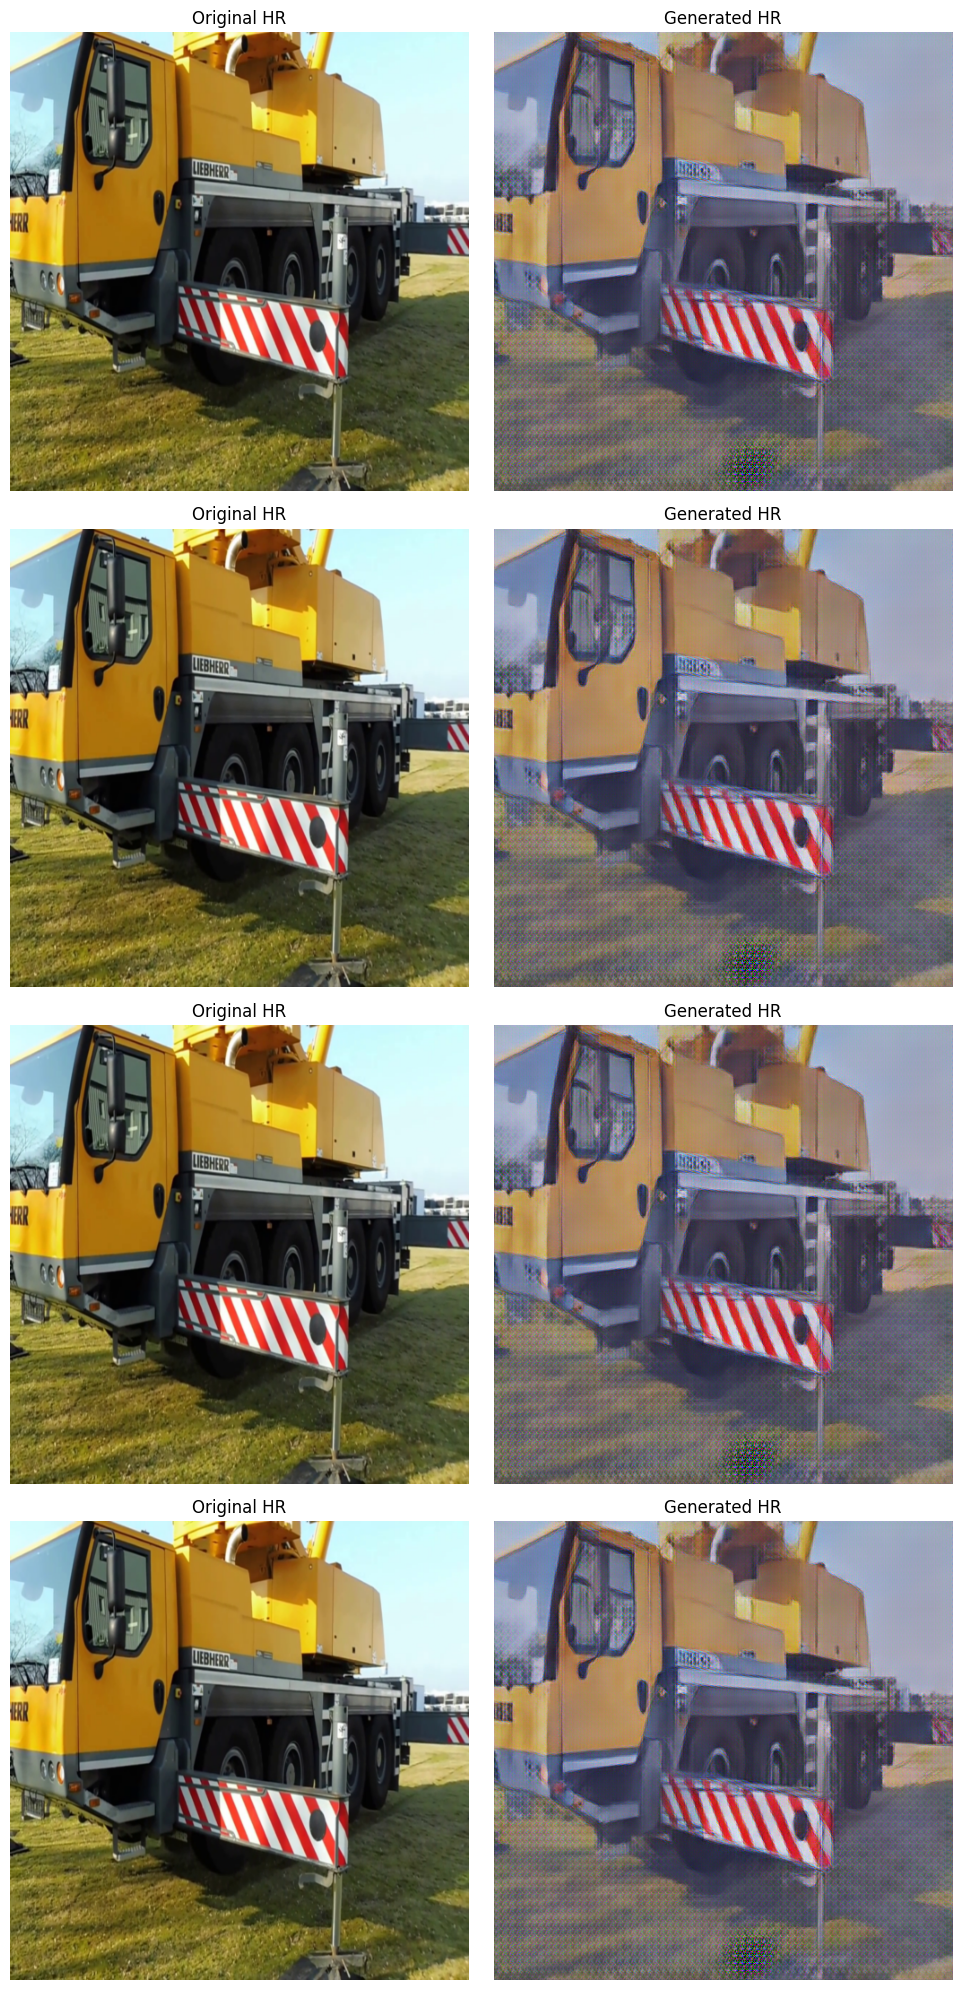

In [22]:
import torch
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt


generator = GeneratorVGG()
generator.load_state_dict(torch.load('saved_models/generator.pth'))
generator.eval()



fig, axs = plt.subplots(4, 2, figsize=(10, 20))

for idx in range(4):
    imgs = next(iter(test_dataloader))

    imgs_lr = Variable(imgs["lr"].type(torch.FloatTensor))

    with torch.no_grad():
        gen_hr = generator(imgs_lr)

    original_hr = imgs["hr"][0].permute(1, 2, 0).numpy()
    generated_hr = gen_hr[0].cpu().permute(1, 2, 0).numpy()

    # Plot original HR image
    axs[idx, 0].imshow(original_hr)
    axs[idx, 0].set_title('Original HR')
    axs[idx, 0].axis('off')

    # Plot generated HR image
    axs[idx, 1].imshow(generated_hr)
    axs[idx, 1].set_title('Generated HR')
    axs[idx, 1].axis('off')

plt.tight_layout()
plt.show()